In [1]:
!pip install -qU "numpy<2.0" "opencv-python-headless==4.10.*"
!pip install -qU ultralytics --no-deps
!pip install ruamel.yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 39.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.2 MB/s eta 0:00:0000:01


# **Copy dataset to working directory**

In [2]:
!cp -r "/kaggle/input/waste-detection/waste detection data/" "/kaggle/working/dataset"

# Generating yaml config file for yolo

In [3]:
from ruamel.yaml import YAML
import os

ROOT_TRAINING_FOLDER = "/kaggle/working/dataset"
# Correct the paths in the data dictionary
data = {
    'train': os.path.join(ROOT_TRAINING_FOLDER, 'train', 'images'),
    'val': os.path.join(ROOT_TRAINING_FOLDER, 'valid', 'images'),
    'nc': 7,
    'names': ['Aluminium', 'Glass', 'Tag', 'cardboard', 'rigid_plastic', 'soft_plastic', 'wood']
}

yaml = YAML()
with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

# Check and verify dataset

In [4]:
from ultralytics.data.utils import check_det_dataset

check_det_dataset('/kaggle/working/data.yaml')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


{'train': '/kaggle/working/dataset/train/images',
 'val': '/kaggle/working/dataset/valid/images',
 'nc': 7,
 'names': {0: 'Aluminium',
  1: 'Glass',
  2: 'Tag',
  3: 'cardboard',
  4: 'rigid_plastic',
  5: 'soft_plastic',
  6: 'wood'},
 'yaml_file': '/kaggle/working/data.yaml',
 'channels': 3,
 'path': PosixPath('/kaggle/working')}

# Training yolo12n-seg 

In [5]:
from ultralytics import YOLO

DATA_YAML = "/kaggle/working/data.yaml"

# COMMON VARS
MODEL_YAML = "yolo12n-seg.yaml"
MODEL_NAME = "yolo12n.pt"
SAVE_NAME = "waste_yolo12n_seg"
EPOCHS = 20
model = YOLO(MODEL_YAML).load(MODEL_NAME)  # build from YAML and transfer weights

# Load a pre-trained YOLOv8 segmentation model
model = YOLO(MODEL_NAME)

results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,           
    imgsz=640,
    batch=8,             
    workers=2,
    device=0,            
    patience=10,          # early stopping
    save=True,
    save_period=5,       # set >0 to save every N epochs
    pretrained=True,
    optimizer="auto",
    name=SAVE_NAME,
    exist_ok=True,
    amp=False,
)

# Train the model with caching disabled, reduced epochs, and on GPU
# results = model.train(data=DATA_YAML, epochs=5, imgsz=640, cache=False, amp=False, device='0')

Transferred 691/753 items from pretrained weights
Ultralytics 8.3.234 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=waste_yolo12n_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1270       4483      0.715       0.68      0.725      0.541
             Aluminium        151        154      0.778      0.714      0.728      0.583
                 Glass        104        116       0.85      0.784      0.872      0.706
                   Tag        267        301      0.628      0.738      0.737        0.5
             cardboard        566       2312      0.639      0.486      0.548      0.321
         rigid_plastic        609        682      0.842      0.679      0.775      0.627
          soft_plastic        429        895      0.585       0.36      0.433      0.234
                  wood         23         23      0.682          1      0.981       0.82
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/waste_yolo12n_seg


# Visualizing And Validating the model

Found runs:
 - /kaggle/working/runs/detect/waste_yolo12n_seg

== detect/waste_yolo12n_seg ==
Metrics file: /kaggle/working/runs/detect/waste_yolo12n_seg/results.csv  — shape: (20, 15)


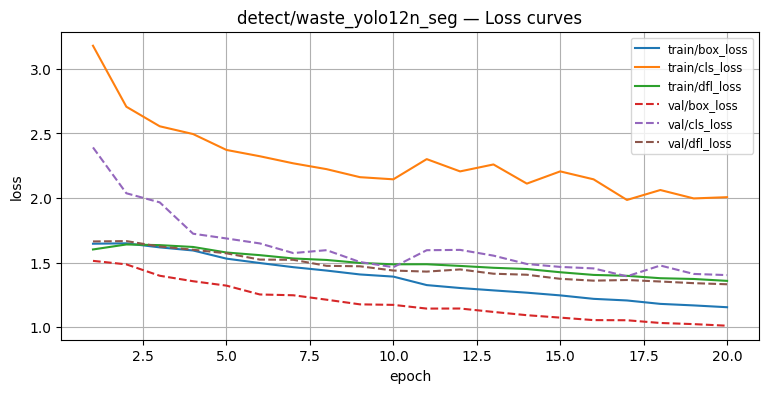

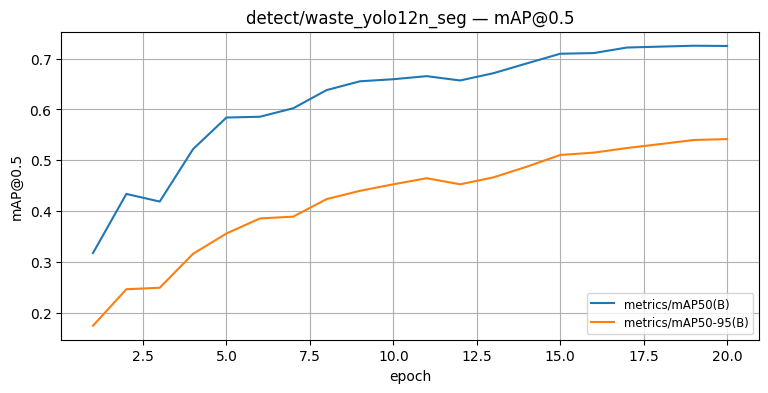


Final metrics summary (extracted from metrics files):


,run,metrics_path,mAP50,loss
0,detect/waste_yolo12n_seg,results.csv,0.54156,1.15595


Saved concise CSV: /kaggle/working/final_metrics_summary.csv


In [6]:
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

RUN_BASES = [
    "/kaggle/working/runs/detect",
]
TARGET_RUN_NAME = SAVE_NAME 
OUT_CSV = "/kaggle/working/final_metrics_summary.csv"

def find_run_dirs(bases, run_name):
    runs = []
    for base in bases:
        candidate = os.path.join(base, run_name)
        if os.path.isdir(candidate):
            runs.append(candidate)
        else:
            if os.path.isdir(base):
                subs = sorted(glob.glob(os.path.join(base, "*")), key=os.path.getmtime, reverse=True)
                for s in subs:
                    if run_name in os.path.basename(s):
                        runs.append(s)
                        break
    return runs

def load_metrics(run_dir):
    candidates = [
        os.path.join(run_dir, "metrics.csv"),
        os.path.join(run_dir, "results.csv"),
        os.path.join(run_dir, "metrics.json"),
        os.path.join(run_dir, "results.json"),
    ]
    candidates += glob.glob(os.path.join(run_dir, "**", "*metrics*.csv"), recursive=True)
    candidates += glob.glob(os.path.join(run_dir, "**", "*.json"), recursive=True)
    seen = set()
    for p in candidates:
        if not p or p in seen:
            continue
        seen.add(p)
        if os.path.exists(p):
            try:
                if p.endswith(".csv"):
                    df = pd.read_csv(p)
                else:
                    with open(p, "r") as f:
                        data = json.load(f)
                    if isinstance(data, list):
                        df = pd.DataFrame(data)
                    elif isinstance(data, dict):
                        df = pd.json_normalize(data)
                    else:
                        continue
                # Normalize column names (keep original but make lower-case mapping handy)
                df.columns = [c if isinstance(c, str) else str(c) for c in df.columns]
                # ensure epoch column exists
                if "epoch" not in df.columns:
                    df.insert(0, "epoch", range(len(df)))
                return df, p
            except Exception:
                continue
    return None, None

def pick_columns(df):
    cols_lower = [c.lower() for c in df.columns]
    loss_cols = [c for c in df.columns if "loss" in c.lower() and df[c].dtype.kind in "fiu"]
    train_loss_cols = [c for c in loss_cols if "val" not in c.lower() and "test" not in c.lower()]
    val_loss_cols = [c for c in loss_cols if "val" in c.lower() or "test" in c.lower()]
    # mAP@0.5
    map50_cols = [c for c in df.columns if "map50" in c.lower() or "m_ap_50" in c.lower() or ("map" in c.lower() and "50" in c.lower())]
    # generic map
    map_cols = [c for c in df.columns if (c.lower().startswith("map") and c not in map50_cols)]
    # IoU
    iou_cols = [c for c in df.columns if "iou" in c.lower() and df[c].dtype.kind in "fiu"]
    # other useful components (box/cls/seg)
    box_cols = [c for c in df.columns if "box" in c.lower() and df[c].dtype.kind in "fiu"]
    cls_cols = [c for c in df.columns if "cls" in c.lower() and df[c].dtype.kind in "fiu"]
    seg_cols = [c for c in df.columns if "seg" in c.lower() and df[c].dtype.kind in "fiu" and "loss" not in c.lower()]
    return {
        "loss": loss_cols,
        "train_loss": train_loss_cols,
        "val_loss": val_loss_cols,
        "map50": map50_cols,
        "map": map_cols,
        "iou": iou_cols,
        "box": box_cols,
        "cls": cls_cols,
        "seg": seg_cols
    }

def plot_run(df, label):
    epoch = df["epoch"] if "epoch" in df.columns else range(len(df))
    cols = pick_columns(df)

    plotted = False
    loss_to_plot = []
    if cols["train_loss"]:
        loss_to_plot += cols["train_loss"]
    if cols["val_loss"]:
        # show val losses as dashed
        loss_to_plot += cols["val_loss"]
    # if no explicit train/val split, plot all loss columns
    if not loss_to_plot and cols["loss"]:
        loss_to_plot = cols["loss"]

    if loss_to_plot:
        plt.figure(figsize=(9,4))
        for c in loss_to_plot:
            style = "--" if "val" in c.lower() or "test" in c.lower() else "-"
            try:
                plt.plot(epoch, df[c], linestyle=style, marker=None, label=c)
            except Exception:
                continue
        plt.title(f"{label} — Loss curves")
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid(True); plt.legend(loc="upper right", fontsize="small")
        plt.show()
        plotted = True

    # 2) mAP@0.5
    if cols["map50"]:
        plt.figure(figsize=(9,4))
        for c in cols["map50"]:
            try:
                plt.plot(epoch, df[c], label=c, marker=None)
            except Exception:
                continue
        plt.title(f"{label} — mAP@0.5")
        plt.xlabel("epoch"); plt.ylabel("mAP@0.5"); plt.grid(True); plt.legend(loc="lower right", fontsize="small")
        plt.show()
        plotted = True
    elif cols["map"]:
        plt.figure(figsize=(9,4))
        for c in cols["map"]:
            try:
                plt.plot(epoch, df[c], label=c)
            except Exception:
                continue
        plt.title(f"{label} — mAP curve")
        plt.xlabel("epoch"); plt.ylabel("mAP"); plt.grid(True); plt.legend(loc="lower right", fontsize="small")
        plt.show()
        plotted = True

    # 3) IoU
    if cols["iou"]:
        plt.figure(figsize=(9,4))
        for c in cols["iou"]:
            try:
                plt.plot(epoch, df[c], label=c)
            except Exception:
                continue
        plt.title(f"{label} — IoU")
        plt.xlabel("epoch"); plt.ylabel("IoU"); plt.grid(True); plt.legend(loc="lower right", fontsize="small")
        plt.show()
        plotted = True

    comp_cols = cols["box"] + cols["cls"] + cols["seg"]
    # remove duplicates and already plotted loss columns
    comp_cols = [c for c in dict.fromkeys(comp_cols) if c not in (cols["loss"] + cols["train_loss"] + cols["val_loss"])]
    if comp_cols:
        plt.figure(figsize=(9,4))
        for c in comp_cols:
            try:
                plt.plot(epoch, df[c], label=c)
            except Exception:
                continue
        plt.title(f"{label} — component metrics (box/cls/seg)")
        plt.xlabel("epoch"); plt.grid(True); plt.legend(loc="upper right", fontsize="small")
        plt.show()
        plotted = True

    if not plotted:
        print(f"{label}: no plotting columns (loss / mAP@0.5 / IoU / box/cls/seg) found in metrics file.")

def final_row_from_df(df):
    if df is None or df.shape[0] == 0:
        return {}
    # use last row by epoch (max epoch) if epoch exists, else last index
    if "epoch" in df.columns:
        last_idx = int(df["epoch"].astype(int).idxmax())
    else:
        last_idx = df.index[-1]
    row = df.iloc[last_idx].to_dict()
    out = {}
    # search keys for mAP50, map, iou, and loss
    for k,v in row.items():
        kl = k.lower()
        if any(x in kl for x in ("map50","m_ap_50","map_50")) and pd.notna(v):
            out["mAP50"] = float(v)
        if kl.startswith("map") and "50" not in kl and pd.notna(v):
            # generic mAP
            out.setdefault("mAP", float(v))
            out.setdefault("IoU", float(v))
        if kl == "loss" and pd.notna(v):
            out.setdefault("loss", float(v))
        if "loss" in kl and "val" not in kl and pd.notna(v):
            out.setdefault("loss", float(v))
    return out

run_dirs = find_run_dirs(RUN_BASES, TARGET_RUN_NAME)
if not run_dirs:
    raise FileNotFoundError(f"No run directories named '{TARGET_RUN_NAME}' found under {RUN_BASES}")

summary_rows = []
print("Found runs:")
for r in run_dirs:
    print(" -", r)

for r in run_dirs:
    label = os.path.basename(os.path.dirname(r)) + "/" + os.path.basename(r) if os.path.dirname(r) else os.path.basename(r)
    df, path = load_metrics(r)
    print(f"\n== {label} ==")
    if df is not None:
        print(f"Metrics file: {path}  — shape: {df.shape}")
        plot_run(df, label)
        final = final_row_from_df(df)
        if final:
            final_row = {"run": label, "metrics_path": os.path.basename(path)}
            final_row.update(final)
            summary_rows.append(final_row)
        else:
            summary_rows.append({"run": label, "metrics_path": os.path.basename(path)})
    else:
        print("No metrics file found for this run. Skipping plots. (If you want, re-run validation with the trained weights to produce numeric metrics.)")
        summary_rows.append({"run": label, "metrics_path": None})

summary_df = pd.DataFrame(summary_rows).fillna("")
if summary_df.shape[0] > 0:
    # reorder columns for readability
    cols = [c for c in ["run", "metrics_path", "mAP50", "mAP", "IoU", "loss"] if c in summary_df.columns]
    summary_df = summary_df[cols]
    print("\nFinal metrics summary (extracted from metrics files):")
    display(summary_df)
    summary_df.to_csv(OUT_CSV, index=False)
    print(f"Saved concise CSV: {OUT_CSV}")
else:
    print("\nNo final metrics extracted from any metrics files.")